In [11]:
import os
import tensorflow as tf

# tces_file = '../mnt/tess/astronet/tces-vetting-v4-toi-train.csv'
# file_pattern = '../mnt/tess/astronet/tfrecords-vetting-5-toi-train/*'
# model_name = 'AstroCNNModelVetting'
# config_name = 'vrevised'
# labels = ['p', 'e', 'n']
tces_file = '../mnt/tess/astronet/tces-v14-test.csv'
file_pattern = '../mnt/tess/astronet/tfrecords-38-test/*'
model_name = 'AstroCNNModel'
config_name = 'final_alpha_1'
labels = ['E', 'N', 'J', 'S', 'B']

filenames = tf.io.gfile.glob(file_pattern)
    
filenames

['../mnt/tess/astronet/tfrecords-38-test/00002-of-00005',
 '../mnt/tess/astronet/tfrecords-38-test/00003-of-00005',
 '../mnt/tess/astronet/tfrecords-38-test/00004-of-00005',
 '../mnt/tess/astronet/tfrecords-38-test/00000-of-00005',
 '../mnt/tess/astronet/tfrecords-38-test/00001-of-00005']

In [12]:
import pandas as pd

tce_table = pd.read_csv(tces_file, header=0, low_memory=False)
print(len(tce_table))
tce_table.head(3)

260


,Astro ID,TIC ID,Final,Decision,av,md,ch,as,mk,et,dm,td,Notes,Epoc,Per,Dur,Depth,SMass,SRad,SRadEst,Tmag,RA,Dec,Split,Year,MaxT,MinT,File,disp_E,disp_J,disp_N,disp_S,disp_B
0,26388,101434215,J,NaN,NaN,J,J,J,J,J,J,J,NaN,1537.03546,19.56597,0.219708,6630,0.940,0.851036,0.873615,12.03630,149.038746,-20.145229,test,3,2279.980851,1517.369555,mk_hlsp_qlp_tess_ffi-s0035-0000000101434215_te...,0,1,0,0,0
1,26395,102062770,NaN,NaN,NaN,B,J,B,J,J,B,B,NaN,1354.45458,0.33779,0.071333,66380,1.050,1.338890,1.318623,12.90040,17.252488,-47.321844,test,3,2114.431097,1354.118781,mk_hlsp_qlp_tess_ffi-s0029-0000000102062770_te...,0,3,0,0,4
2,26402,106747837,NaN,NaN,NaN,J,J,J,J,J,N,J,NaN,1490.53977,1.91041,0.152833,2693,1.532,2.536420,2.445464,8.68737,110.112187,-24.500660,test,3,2254.062921,1491.639880,mk_hlsp_qlp_tess_ffi-s0034-0000000106747837_te...,0,6,1,0,0


In [13]:
series = {}

for filename in filenames:
  tfr = tf.data.TFRecordDataset(filename)
  num_records = 0
  for record in tfr:
    num_records += 1
    ex = tf.train.Example.FromString(record.numpy())
    for k in ex.features.feature.keys():
      f = ex.features.feature[k]
      if f.int64_list.value:
        v = f.int64_list.value[0]
      elif f.float_list.value:
        v = f.float_list.value[0]
      elif f.bytes_list.value:
        v = f.bytes_list.value[0].decode()
      else:
        continue

      if k not in series:
        series[k] = []
      series[k].append(v)
  print(filename, num_records)

2023-05-19 15:21:52.337936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-19 15:21:52.463658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


../mnt/tess/astronet/tfrecords-38-test/00002-of-00005 52
../mnt/tess/astronet/tfrecords-38-test/00003-of-00005 52


2023-05-19 15:21:52.569483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-19 15:21:52.670361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


../mnt/tess/astronet/tfrecords-38-test/00004-of-00005 52
../mnt/tess/astronet/tfrecords-38-test/00000-of-00005 52
../mnt/tess/astronet/tfrecords-38-test/00001-of-00005 52


2023-05-19 15:21:52.779229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


In [14]:
import pandas as pd

examples_table = pd.DataFrame.from_dict(series)

pd.set_option('display.max_columns', None)
# examples_table[['secondary_scale']].describe()
examples_table.describe()

,local_view,local_scale_present,secondary_std,local_scale_present_0.3,local_std,global_view_double_period,disp_N,star_mass_present,local_std_even,global_view_half_period_0.3,local_view_half_period_0.3,local_mask,secondary_view_0.3,global_view_double_period_mask_0.3,global_view_double_period_mask,global_view_0.3,astro_id,local_std_odd,local_view_odd,global_view_double_period_std_0.3,local_std_odd_0.3,global_view_half_period,star_rad,global_view_double_period_mask_5.0,secondary_scale_5.0,global_mask_5.0,local_mask_odd,global_view_half_period_std,local_mask_5.0,local_view_half_period_5.0,star_rad_est,local_view_half_period_std_5.0,global_view_half_period_5.0,secondary_view_5.0,local_view_odd_5.0,local_std_even_5.0,local_view_even_5.0,local_view_even,global_transit_mask_5.0,global_view_half_period_mask_0.3,secondary_scale_present_0.3,disp_J,global_transit_mask,local_view_even_0.3,n_points,global_mask_0.3,global_view_double_period_std,secondary_scale_present_5.0,secondary_phase_5.0,secondary_phase_0.3,local_scale_present_5.0,secondary_std_0.3,local_mask_0.3,local_std_even_0.3,secondary_mask_0.3,local_mask_even_0.3,global_std_5.0,local_mask_odd_5.0,global_view,secondary_scale_present,secondary_mask_5.0,local_std_0.3,secondary_mask,Period,sample_segments_view,secondary_std_5.0,local_view_0.3,local_view_half_period_std,local_view_half_period_mask_0.3,local_view_half_period_mask,sample_segments_local_view_5.0,disp_S,n_folds,global_view_half_period_std_0.3,disp_E,local_mask_odd_0.3,secondary_phase,star_rad_present,global_view_5.0,star_rad_est_present,global_view_double_period_5.0,local_view_half_period_std_0.3,local_mask_even,sample_segments_local_view_0.3,local_scale_0.3,local_scale,local_view_half_period,global_view_double_period_std_5.0,Duration,global_view_half_period_mask,local_view_half_period_mask_5.0,sample_segments_view_0.3,local_std_odd_5.0,Tmag,local_std_5.0,secondary_scale,local_view_5.0,Transit_Depth,global_mask,star_mass,global_std_0.3,sample_segments_view_5.0,global_view_half_period_std_5.0,local_view_odd_0.3,disp_B,global_std,sample_segments_local_view,global_view_double_period_0.3,global_transit_mask_0.3,local_scale_5.0,secondary_view,global_view_half_period_mask_5.0,local_mask_even_5.0,secondary_scale_0.3
count,260.000000,260.0,260.000000,260.000000,260.000000,260.000000,260.000000,260.0,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.0,260.000000,260.000000,260.000000,260.0,260.000000,260.000000,260.000000,260.000000,260.0,260.000000,260.000000,260.0,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.0,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.0,260.000000,260.0,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,2.600000e+02,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.0,260.000000,260.000000,260.000000,260.000000,260.000000
mean,0.050710,1.0,3.282200,0.984615,3.328796,0.032003,0.061538,1.0,3.246153,0.112060,0.110579,0.980769,-0.032197,0.915385,0.923077,0.016630,27621.050000,3.440846,0.053923,1.108032,2.356507,0.091122,1.680520,0.923077,0.012555,0.961538,0.926923,4.275050,0.980769,0.089778,1.651912,10.298756,0.111221,0.040827,0.069582,3.399516,1.597343,0.045315,0.0,0.973077,0.984615,1.626923,0.0,-0.014364,8708.103846,0.953846,0.931164,1.0,0.513184,0.505169,1.0,2.313807,0.969231,2.266054,0.980769,0.888462,1.233551,0.926923,0.027647,1.0,0.992308,2.3489

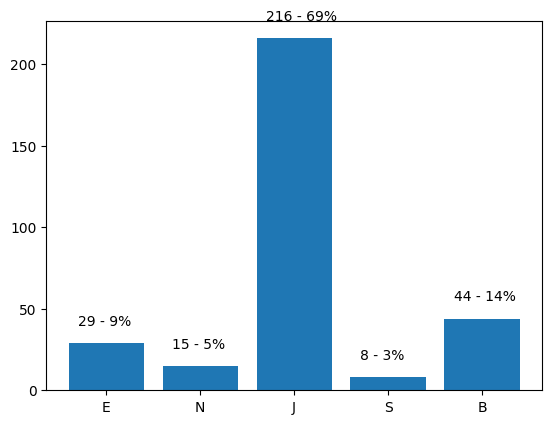

In [15]:
from matplotlib import pyplot as plt

counts = [sum(examples_table['disp_{}'.format(l)] > 0) for l in labels]
ax = plt.bar(labels, counts)
for i in range(len(labels)):
    b = ax[i]
    height = b.get_height()
    x, y = b.get_xy()
    plt.annotate(
        '{} - {:.0%}'.format(counts[i], counts[i] / sum(counts)),
        (x + 0.1, y + height + 11))

In [16]:
examples_table.head(3)

,local_view,local_scale_present,secondary_std,local_scale_present_0.3,local_std,global_view_double_period,disp_N,star_mass_present,local_std_even,global_view_half_period_0.3,local_view_half_period_0.3,local_mask,secondary_view_0.3,global_view_double_period_mask_0.3,global_view_double_period_mask,global_view_0.3,astro_id,local_std_odd,local_view_odd,global_view_double_period_std_0.3,local_std_odd_0.3,global_view_half_period,star_rad,global_view_double_period_mask_5.0,secondary_scale_5.0,global_mask_5.0,local_mask_odd,global_view_half_period_std,local_mask_5.0,local_view_half_period_5.0,star_rad_est,local_view_half_period_std_5.0,global_view_half_period_5.0,secondary_view_5.0,local_view_odd_5.0,local_std_even_5.0,local_view_even_5.0,local_view_even,global_transit_mask_5.0,global_view_half_period_mask_0.3,secondary_scale_present_0.3,disp_J,global_transit_mask,local_view_even_0.3,n_points,global_mask_0.3,global_view_double_period_std,secondary_scale_present_5.0,secondary_phase_5.0,secondary_phase_0.3,local_scale_present_5.0,secondary_std_0.3,local_mask_0.3,local_std_even_0.3,secondary_mask_0.3,local_mask_even_0.3,global_std_5.0,local_mask_odd_5.0,global_view,secondary_scale_present,secondary_mask_5.0,local_std_0.3,secondary_mask,Period,sample_segments_view,secondary_std_5.0,local_view_0.3,local_view_half_period_std,local_view_half_period_mask_0.3,local_view_half_period_mask,sample_segments_local_view_5.0,disp_S,n_folds,global_view_half_period_std_0.3,disp_E,local_mask_odd_0.3,secondary_phase,star_rad_present,global_view_5.0,star_rad_est_present,global_view_double_period_5.0,local_view_half_period_std_0.3,local_mask_even,sample_segments_local_view_0.3,local_scale_0.3,local_scale,local_view_half_period,global_view_double_period_std_5.0,Duration,global_view_half_period_mask,local_view_half_period_mask_5.0,sample_segments_view_0.3,local_std_odd_5.0,Tmag,local_std_5.0,secondary_scale,local_view_5.0,Transit_Depth,global_mask,star_mass,global_std_0.3,sample_segments_view_5.0,global_view_half_period_std_5.0,local_view_odd_0.3,disp_B,global_std,sample_segments_local_view,global_view_double_period_0.3,global_transit_mask_0.3,local_scale_5.0,secondary_view,global_view_half_period_mask_5.0,local_mask_even_5.0,secondary_scale_0.3
0,0.148156,1.0,0.579719,1.0,0.141781,0.000000,0,1.0,0.618700,-0.011799,0.006219,1.0,0.000296,0.0,0.0,0.001943,27366,0.117293,0.086454,0.000000,0.002911,-0.659023,0.813674,0.0,0.007443,1.0,1.0,0.986319,1.0,0.219912,0.786299,0.262370,-0.052191,1.399304,1.486100,1.029682,0.724682,-0.054621,0.0,1.0,1.0,1,0.0,0.005682,4088.0,1.0,0.000000,1.0,0.472929,0.458313,1.0,0.023894,1.0,0.018823,1.0,1.0,0.110073,1.0,-0.093867,1.0,1.0,0.016292,1.0,25.762510,0.000000,1.288199,0.005142,1.298415,1.0,1.0,0.000000,0,6.0,0.062227,0,1.0,0.750637,1.0,0.112931,1.0,0.000000,0.075998,1.0,0.000000,0.059078,0.001808,-0.088220,0.000000,0.941375,1.0,1.0,0.000000,0.101961,11.1590,0.597392,0.000954,1.300650,12890.0,1.0,0.893,0.007007,0.000000,0.182052,0.003600,0,0.236249,0.000000,0.00000,0.0,0.001092,-0.060783,1.0,1.0,0.001138
1,0.236494,1.0,0.129750,1.0,0.244355,0.040525,0,1.0,0.000000,0.517166,0.085821,1.0,-0.315661,1.0,1.0,-0.221834,27375,0.240561,0.269893,8.016307,0.756555,0.233908,1.473130,1.0,0.000758,1.0,1.0,1.797998,1.0,-0.272435,1.477175,0.865937,0.301602,-0.883287,-0.361323,0.000000,-0.611590,0.002703,0.0,1.0,1.0,1,0.0,-0.445124,20612.0,1.0,1.220428,1.0,0.215436,0.212574,1.0,0.875860,1.0,0.000000,1.0,1.0,0.781859,1.0,-0.019647,1.0,1.0,0.769481,1.0,56.770161,1.000015,0.888910,0.337342,0.971949,1.0,1.0,1.000006,0,13.0,3.853121,0,1.0,0.205897,1.0,-0.049869,1.0,0.008396,0.952244,1.0,0.999995,0.000572,0.003466,0.436841,0.592721,0.090250,1.0,1.0,0.999995,0.481161,9.8366,0.455786,0.000507,-0.411376,1180.0,1.0,1.070,5.079360,1.000006,2.046053,0.449123,0,1.061976,1.000015,-0.13590,0.0,0.000929,0.215049,1.0,1.0,0.000386
2,-0.183615,1.0,0.496148,1.0,0.362949,-0.089875,0,1.0,0.838055,0.442147,0.287666,1.0,0.025072,1.0,1.0,0.123895,27377,0.095490,-0.4272

In [17]:
tce_table[tce_table.index == 8209]

,Astro ID,TIC ID,Final,Decision,av,md,ch,as,mk,et,dm,td,Notes,Epoc,Per,Dur,Depth,SMass,SRad,SRadEst,Tmag,RA,Dec,Split,Year,MaxT,MinT,File,disp_E,disp_J,disp_N,disp_S,disp_B


In [18]:
import numpy as np

print('Label mismtaches between TCE and tfrecords:')
np.array(set(tce_table[tce_table[f'disp_{labels[0]}'] > 0]['Astro ID'].values)
    - set(examples_table[examples_table[f'disp_{labels[0]}'] > 0]['astro_id'].values))

Label mismtaches between TCE and tfrecords:


array(set(), dtype=object)

In [19]:
import tensorflow as tf

from astronet import models
from astronet.astro_cnn_model import input_ds

config = models.get_model_config(model_name, config_name)

ds = input_ds.build_dataset(
      file_pattern=file_pattern,
      input_config=config.inputs,
      batch_size=1,
      include_labels=False,
      shuffle_filenames=False,
      repeat=1,
      include_identifiers=True)
labels_ds = input_ds.build_dataset(
      file_pattern=file_pattern,
      input_config=config.inputs,
      batch_size=1,
      include_labels=True,
      shuffle_filenames=False,
      repeat=1,
      include_identifiers=True)
labels_iter = iter(labels_ds)

label_index = {k.lower(): i for i, k in enumerate(config.inputs.label_columns)}
cols = ["disp_E", "disp_N", "disp_J", "disp_S", "disp_B"]

all_ids = []
bad_labels = []
for d in ds:
  lab = next(labels_iter)
  
  def lam(e):
    if e.dtype == tf.int64:
        return e
    if tf.reduce_any(tf.math.is_nan(e)):
        tf.print(e, summarize=-1)
        raise ValueError('data has NaNs.')
    return e
  ex_id = d[1].numpy().item()
  all_ids.append(ex_id)
  
  assert lab[0]['duration'] == d[0]['duration']
  rec = tce_table[tce_table['Astro ID'] == ex_id]
  for c in cols:
    if (lab[1][0][label_index[c.lower()]].numpy() == 0) != (rec[c].values[0] == 0):
      bad_labels.append(ex_id)
      print('bad example: ', ex_id)
      print(rec)
      print(cols)
      print(lab[1][0])
      break
  if bad_labels:
    break
  
  try:
    tf.nest.map_structure(lam, d)
  except ValueError as e:
    print(e)
    print(d[1])
    break
else:
  print('No NaNs or mismtached labels found.')

if len(all_ids) == len(set(all_ids)):
  print('No duplicates found.')
else:
  print('Found duplicates!', len(all_ids) - len(set(all_ids)))
  print([t for t in set(all_ids) if all_ids.count(t) > 1])

2023-05-19 15:22:12.644128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5]
	 [[{{node Placeholder/_0}}]]
2023-05-19 15:22:12.840531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5]
	 [[{{node Placeholder/_0}}]]


No NaNs or mismtached labels found.
No duplicates found.


In [24]:
def astro_id(tic_id):
  return tce_table[tce_table['TIC ID'] == tic_id]['Astro ID'].values[0]

In [25]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from astronet.preprocess import preprocess


tess_data_dir = '../mnt/tess/lc'

def find_tce(astro_id):
  with tf.device('cpu'):
    for filename in filenames:
      tfr = tf.data.TFRecordDataset(filename)
      for record in tfr:
        ex = tf.train.Example.FromString(record.numpy())
        if (ex.features.feature["astro_id"].int64_list.value[0] == astro_id):
          print('TIC ID:', tic_id)
          for l in labels:
              print(f'{l}:', ex.features.feature[f"disp_{l}"].int64_list.value[0])
          print('Duration:', ex.features.feature["Duration"].float_list.value[0])
          return ex

    raise ValueError("{} not found in files: {}".format(astro_id, filenames))

In [26]:
ds = ds.cache()
def plot_ds_tce(ds, astro_id):
    for d in ds:
        if d[1] == astro_id:
            for k, v in d[0].items():
                if k.startswith('local_'):
                    continue
                if k.startswith('global_'):
                    continue
                if k.startswith('secondary_'):
                    continue
                if k.startswith('sample_'):
                    continue
                print(f'{k:25}: {v.numpy()}')
            global_view = np.array(d[0]['global_view'][0].numpy())
            local_view = np.array(d[0]['local_view'][0].numpy())
            secondary_view = np.array(d[0]['secondary_view'][0].numpy())
            fig, axes = plt.subplots(2, 3, figsize=(20, 12))
            axes[0, 0].plot(global_view, '.-')
            axes[0, 1].plot(local_view, '.-')
            axes[0, 2].plot(secondary_view, '.-')
            axes[1, 0].plot(d[0]['global_mask'][0].numpy(), '.-')
            axes[1, 1].plot(d[0]['global_view_0.3'][0].numpy(), '.-')
            axes[1, 2].plot(d[0]['global_view_5.0'][0].numpy(), '.-')
            plt.show()
            plt.close('all')
            return

2023-05-19 15:25:42.600144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5]
	 [[{{node Placeholder/_0}}]]
2023-05-19 15:25:42.600830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5]
	 [[{{node Placeholder/_0}}]]


duration                 : [[-0.05881466]]
period                   : [[ 0.11250913]]
tmag                     : [[ 1.764606]]
transit_depth            : [[ 0.32976714]]
n_folds                  : [[ 0.5]]
star_mass                : [[ 0.24412055]]
star_mass_present        : [[ 1.]]
star_rad                 : [[-0.58069515]]
star_rad_est             : [[-0.22788821]]
star_rad_est_present     : [[ 1.]]
star_rad_present         : [[ 1.]]


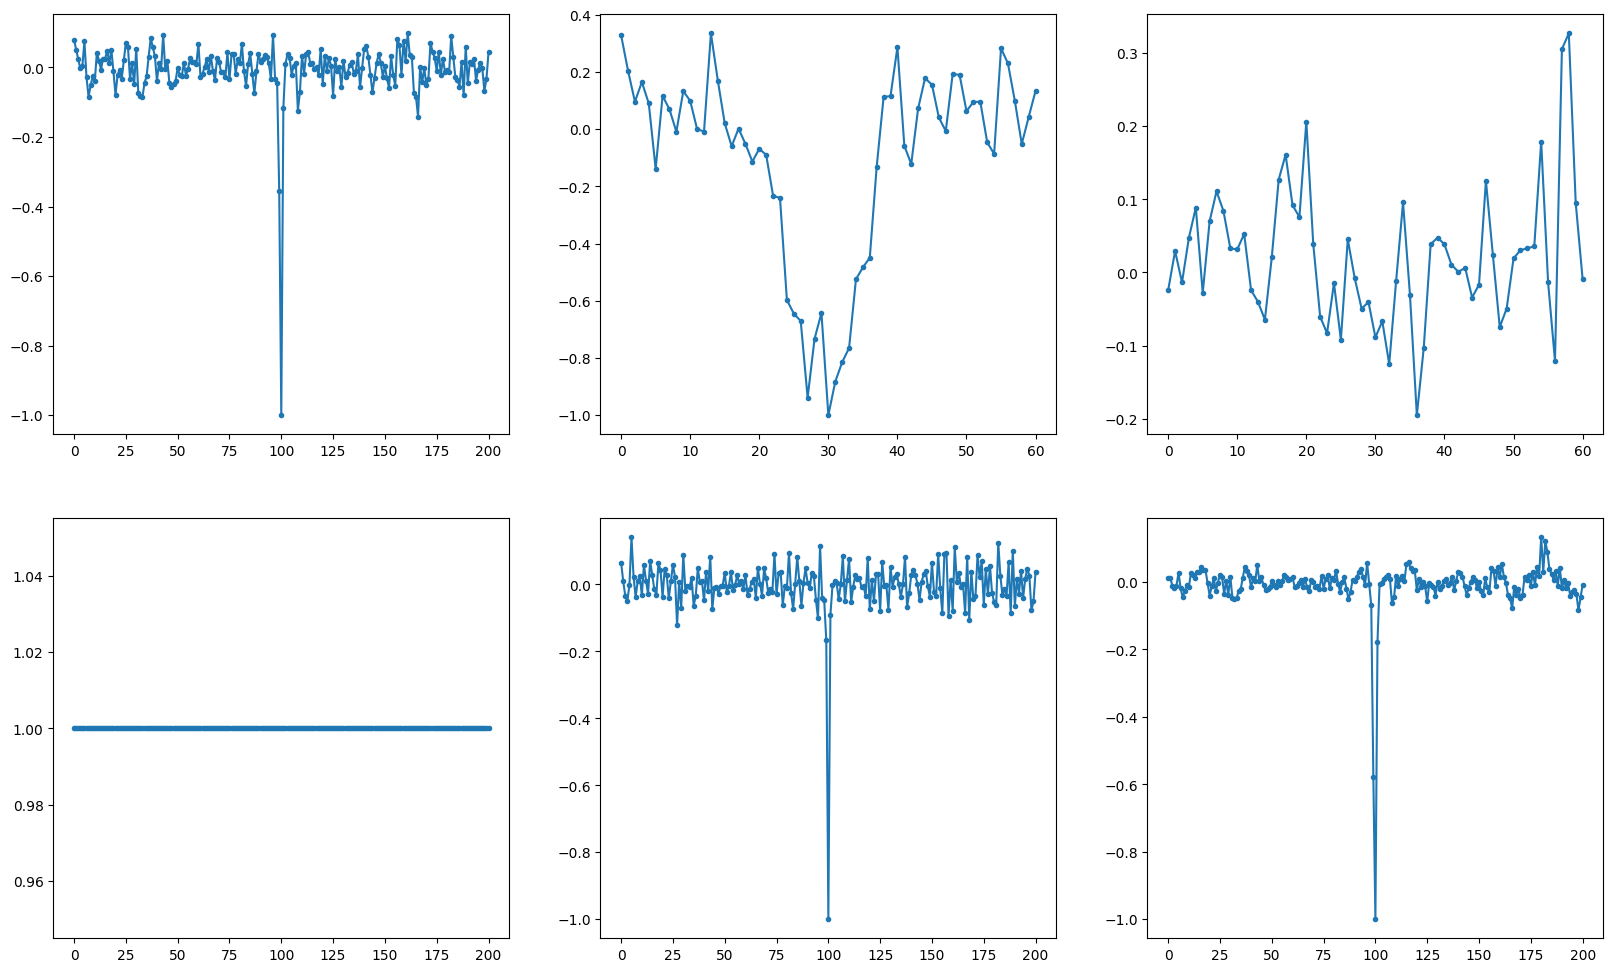

2023-05-19 15:25:44.200484: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-05-19 15:25:44.201316: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [28]:
tic_id = 101434215
plot_ds_tce(ds, astro_id(tic_id))

In [29]:
tce_table[tce_table['TIC ID'] == tic_id]

,Astro ID,TIC ID,Final,Decision,av,md,ch,as,mk,et,dm,td,Notes,Epoc,Per,Dur,Depth,SMass,SRad,SRadEst,Tmag,RA,Dec,Split,Year,MaxT,MinT,File,disp_E,disp_J,disp_N,disp_S,disp_B
0,26388,101434215,J,NaN,NaN,J,J,J,J,J,J,J,NaN,1537.03546,19.56597,0.219708,6630,0.94,0.851036,0.873615,12.0363,149.038746,-20.145229,test,3,2279.980851,1517.369555,mk_hlsp_qlp_tess_ffi-s0035-0000000101434215_te...,0,1,0,0,0


In [30]:
astro_id(tic_id)

26388

In [31]:
examples_table[examples_table['astro_id'] == astro_id(tic_id)]

,local_view,local_scale_present,secondary_std,local_scale_present_0.3,local_std,global_view_double_period,disp_N,star_mass_present,local_std_even,global_view_half_period_0.3,local_view_half_period_0.3,local_mask,secondary_view_0.3,global_view_double_period_mask_0.3,global_view_double_period_mask,global_view_0.3,astro_id,local_std_odd,local_view_odd,global_view_double_period_std_0.3,local_std_odd_0.3,global_view_half_period,star_rad,global_view_double_period_mask_5.0,secondary_scale_5.0,global_mask_5.0,local_mask_odd,global_view_half_period_std,local_mask_5.0,local_view_half_period_5.0,star_rad_est,local_view_half_period_std_5.0,global_view_half_period_5.0,secondary_view_5.0,local_view_odd_5.0,local_std_even_5.0,local_view_even_5.0,local_view_even,global_transit_mask_5.0,global_view_half_period_mask_0.3,secondary_scale_present_0.3,disp_J,global_transit_mask,local_view_even_0.3,n_points,global_mask_0.3,global_view_double_period_std,secondary_scale_present_5.0,secondary_phase_5.0,secondary_phase_0.3,local_scale_present_5.0,secondary_std_0.3,local_mask_0.3,local_std_even_0.3,secondary_mask_0.3,local_mask_even_0.3,global_std_5.0,local_mask_odd_5.0,global_view,secondary_scale_present,secondary_mask_5.0,local_std_0.3,secondary_mask,Period,sample_segments_view,secondary_std_5.0,local_view_0.3,local_view_half_period_std,local_view_half_period_mask_0.3,local_view_half_period_mask,sample_segments_local_view_5.0,disp_S,n_folds,global_view_half_period_std_0.3,disp_E,local_mask_odd_0.3,secondary_phase,star_rad_present,global_view_5.0,star_rad_est_present,global_view_double_period_5.0,local_view_half_period_std_0.3,local_mask_even,sample_segments_local_view_0.3,local_scale_0.3,local_scale,local_view_half_period,global_view_double_period_std_5.0,Duration,global_view_half_period_mask,local_view_half_period_mask_5.0,sample_segments_view_0.3,local_std_odd_5.0,Tmag,local_std_5.0,secondary_scale,local_view_5.0,Transit_Depth,global_mask,star_mass,global_std_0.3,sample_segments_view_5.0,global_view_half_period_std_5.0,local_view_odd_0.3,disp_B,global_std,sample_segments_local_view,global_view_double_period_0.3,global_transit_mask_0.3,local_scale_5.0,secondary_view,global_view_half_period_mask_5.0,local_mask_even_5.0,secondary_scale_0.3
156,0.327959,1.0,0.160443,1.0,0.151666,0.007229,0,1.0,0.151666,-0.409362,1.038974,1.0,0.082866,1.0,1.0,0.064461,26388,0.0,0.0,0.192116,0.0,-0.307616,0.851036,1.0,0.002162,1.0,0.0,0.754968,1.0,0.81526,0.873615,1.294761,-0.444607,0.053683,0.0,0.079637,0.173846,0.327959,0.0,1.0,1.0,1,0.0,0.432304,4152.0,1.0,0.09975,1.0,0.389864,0.17988,1.0,0.132537,1.0,0.221086,1.0,1.0,0.082063,0.0,0.079451,1.0,1.0,0.221086,1.0,19.565969,0.0,0.010994,0.432304,0.935202,1.0,1.0,0.0,0,9.0,1.337376,0,0.0,0.660486,1.0,0.011288,1.0,-0.00005,1.467626,1.0,0.0,0.005921,0.008592,0.621374,0.051926,0.219708,1.0,1.0,0.0,0.0,12.0363,0.079637,0.001843,0.173846,6630.0,1.0,0.94,0.202245,0.0,1.076176,0.0,0,0.13988,0.0,-0.05892,0.0,0.016379,-0.024174,1.0,1.0,0.001053


In [35]:
!ls ../mnt/tess/lc-v | grep 237320326

ls: cannot access ../mnt/tess/lc-v: No such file or directory


In [34]:
tic_id = 101434215
tce = find_tce(astro_id(tic_id))

list(tce.features.feature.keys())

2023-05-19 15:25:59.556825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-19 15:25:59.653266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-19 15:25:59.737051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{n

TIC ID: 101434215
E: 0
N: 0
J: 1
S: 0
B: 0
Duration: 0.21970833837985992


2023-05-19 15:25:59.814223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


['local_view',
 'local_scale_present',
 'secondary_std',
 'local_scale_present_0.3',
 'local_std',
 'global_view_double_period',
 'disp_N',
 'star_mass_present',
 'local_std_even',
 'global_view_half_period_0.3',
 'local_view_half_period_0.3',
 'local_mask',
 'secondary_view_0.3',
 'global_view_double_period_mask_0.3',
 'global_view_double_period_mask',
 'global_view_0.3',
 'astro_id',
 'local_std_odd',
 'local_view_odd',
 'global_view_double_period_std_0.3',
 'local_std_odd_0.3',
 'global_view_half_period',
 'star_rad',
 'global_view_double_period_mask_5.0',
 'secondary_scale_5.0',
 'global_mask_5.0',
 'local_mask_odd',
 'global_view_half_period_std',
 'local_mask_5.0',
 'local_view_half_period_5.0',
 'star_rad_est',
 'local_view_half_period_std_5.0',
 'global_view_half_period_5.0',
 'secondary_view_5.0',
 'local_view_odd_5.0',
 'local_std_even_5.0',
 'local_view_even_5.0',
 'local_view_even',
 'global_transit_mask_5.0',
 'global_view_half_period_mask_0.3',
 'secondary_scale_present_0